# Image segmentation of Synthetic Unity data

In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [9]:
path = Path('data/captures')
path.ls()

[PosixPath('data/captures/train'), PosixPath('data/captures/val')]

# Data

In [10]:
fnames = list((path / 'train').glob('*img*'))
fnames[:3]

[PosixPath('data/captures/train/image_00414_img.png'),
 PosixPath('data/captures/train/image_00246_img.png'),
 PosixPath('data/captures/train/image_01971_img.png')]

In [11]:
lbl_names = list((path / 'train').glob('*layer*'))
lbl_names[:3]

[PosixPath('data/captures/train/image_00675_layer.png'),
 PosixPath('data/captures/train/image_00009_layer.png'),
 PosixPath('data/captures/train/image_01667_layer.png')]

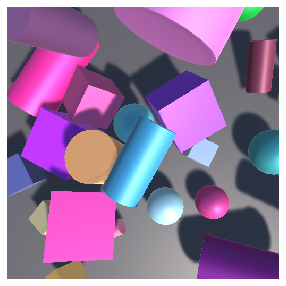

In [12]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [13]:
get_y_fn = lambda x: str(x).replace('img', 'layer')

In [14]:
open_image(get_y_fn(img_f), convert_mode='L').data.unique()

tensor([0.0000, 0.0157, 0.0196, 0.0314, 0.0353, 0.0392])

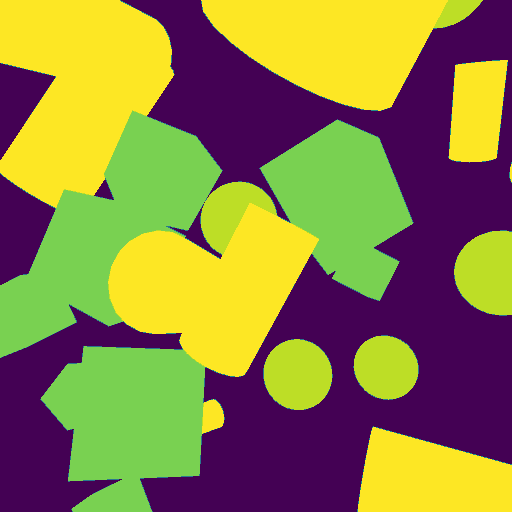

In [15]:
mask = open_mask(get_y_fn(img_f))
mask

In [16]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([512, 512]), tensor([[[10, 10, 10,  ...,  0,  0,  0],
          [10, 10, 10,  ...,  0,  0,  0],
          [10, 10, 10,  ...,  0,  0,  0],
          ...,
          [ 0,  0,  0,  ..., 10, 10, 10],
          [ 0,  0,  0,  ..., 10, 10, 10],
          [ 0,  0,  0,  ..., 10, 10, 10]]]))

In [17]:
codes = np.array(["0", "1", "2", "3", "4", "5", "6", "7", "Cube", "Sphere", "Sphere"])

# Data

In [18]:
size = src_size // 2
bs = 8

In [19]:
def just_image(x):
    return 'img' in str(x)

src = (SegmentationItemList.from_folder(path)
           .filter_by_func(just_image)
           .split_by_folder(train='train', valid='val')
           .label_from_func(get_y_fn, classes=codes))
src

LabelLists;

Train: LabelList (1999 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/captures;

Valid: LabelList (400 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/captures;

Test: None

In [20]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
            .databunch(bs=bs)
            .normalize(imagenet_stats))

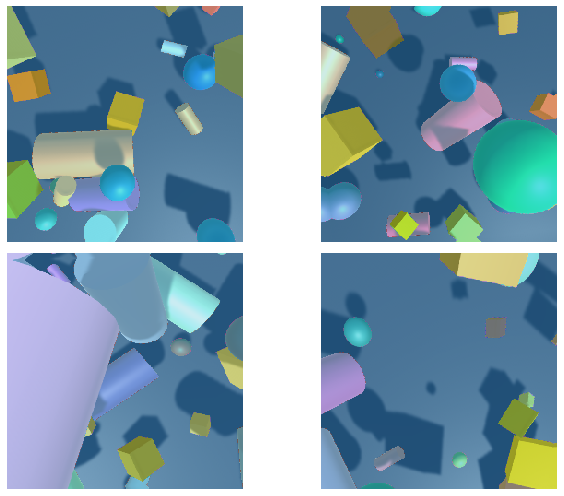

In [21]:
data.show_batch(2, figsize=(10, 7))

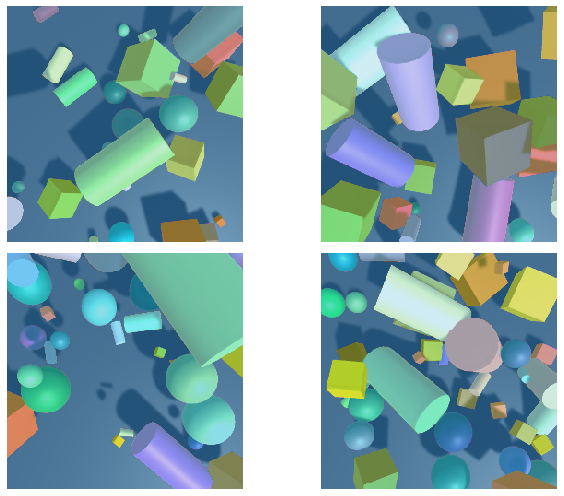

In [22]:
data.show_batch(2, figsize=(10, 7), ds_type=DatasetType.Valid)

# Model

In [23]:
name2id = {v: k for k, v in enumerate(codes)}
void_code = name2id['0']

def acc_segmentation(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [24]:
metrics = acc_segmentation

In [25]:
wd = 1e-2

In [26]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


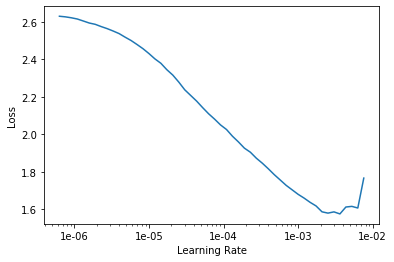

In [27]:
lr_find(learn)
learn.recorder.plot()

In [28]:
lr = 1e-3

In [29]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_segmentation,time
0,0.317766,0.255619,0.787366,01:09
1,0.187791,0.149391,0.902705,01:09
2,0.151968,0.119252,0.919578,01:09
3,0.122207,0.113839,0.904954,01:10
4,0.099892,0.085204,0.934920,01:10
5,0.091764,0.102278,0.936413,01:09
6,0.081699,0.077300,0.935283,01:10
7,0.079451,0.064231,0.943778,01:09
8,0.063701,0.066729,0.942857,01:09
9,0.046125,0.049008,0.956338,01:09


In [30]:
learn.save('stage-1')

In [31]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (1999 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: data/captures;

Valid: LabelList (400 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: data/captures;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2

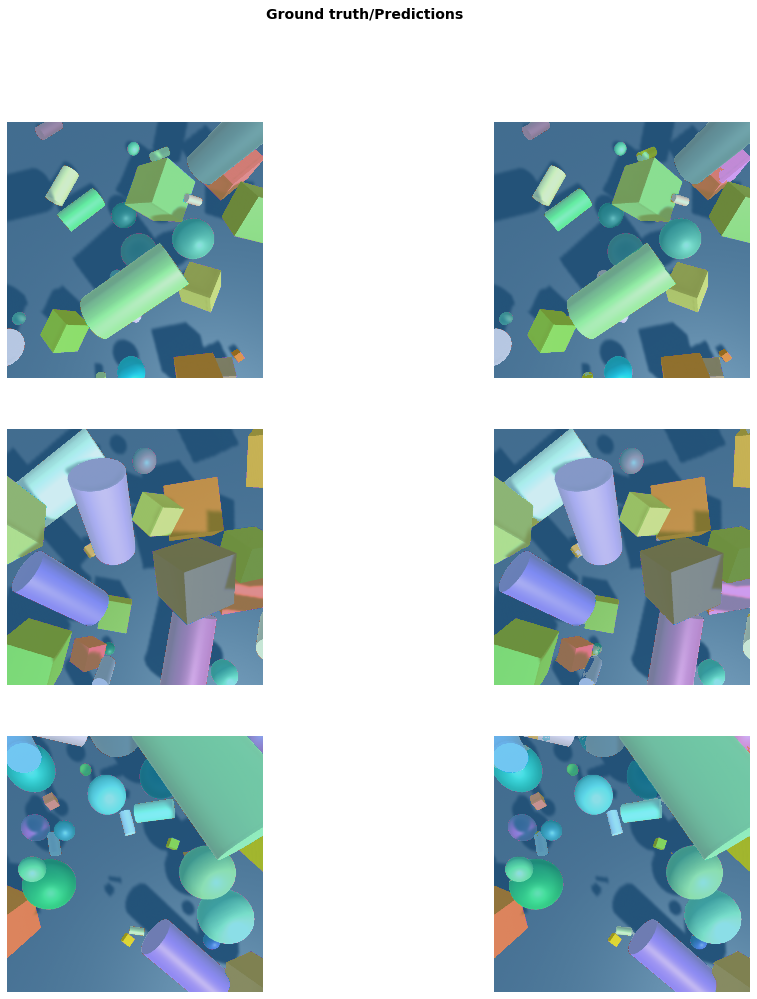

In [32]:
learn.show_results(rows=3, figsize=(16, 16))

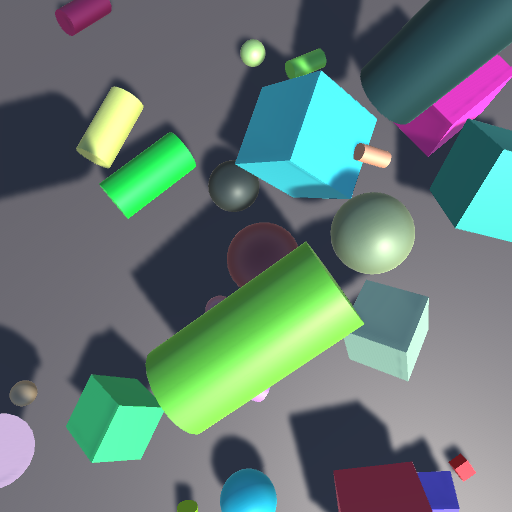

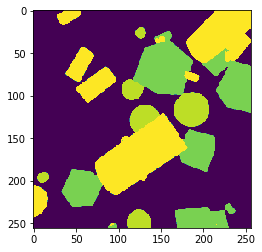

In [33]:
img = open_image((path / 'val').ls()[0])
display(img)
plt.imshow(learn.predict(img)[1].squeeze())

In [34]:
learn.unfreeze()

In [35]:
lrs = slice(lr/400,lr/4)

In [36]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_segmentation,time
0,0.039269,0.049068,0.956772,01:13
1,0.038986,0.049054,0.956723,01:13
2,0.038114,0.048078,0.958202,01:13
3,0.037794,0.048360,0.957556,01:13
4,0.038272,0.051468,0.955391,01:13
5,0.035842,0.048720,0.957875,01:13
6,0.034225,0.048241,0.958678,01:13
7,0.034000,0.053096,0.956619,01:13
8,0.032863,0.050175,0.958458,01:13
9,0.035347,0.053701,0.957503,01:13


In [37]:
learn.save('stage-2');

# Go big

In [38]:
size = src_size
bs=3

In [39]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [40]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [41]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


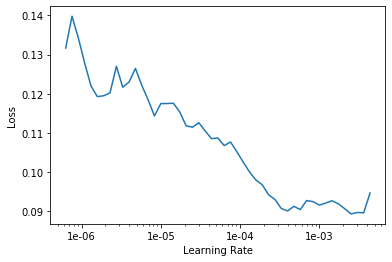

In [42]:
lr_find(learn)
learn.recorder.plot()

In [43]:
lr=1e-3

In [44]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_segmentation,time
0,0.045498,0.048319,0.961108,04:28
1,0.040510,0.039933,0.967348,04:26
2,0.050407,0.060267,0.954969,04:26
3,0.053134,0.050609,0.961681,04:26
4,0.049040,0.044585,0.965374,04:26
5,0.046578,0.041247,0.964545,04:26
6,0.047954,0.064384,0.954738,04:26
7,0.047680,0.044789,0.969720,04:26
8,0.031770,0.039977,0.969178,04:26
9,0.023334,0.027422,0.978211,04:25


In [45]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_segmentation,time
0,0.021303,0.025053,0.980058,04:25
1,0.023575,0.026226,0.978597,04:25
2,0.022387,0.028510,0.977923,04:26
3,0.027428,0.038115,0.973396,04:26
4,0.033907,0.040505,0.973027,04:26
5,0.028502,0.045132,0.965488,04:26
6,0.033197,0.040830,0.972762,04:26
7,0.043547,0.070546,0.963265,04:26
8,0.026273,0.029160,0.976839,04:26
9,0.019444,0.025486,0.979717,04:26


In [46]:
 learn.save('stage-1-big')

In [47]:
learn.load('stage-1-big')

Learner(data=ImageDataBunch;

Train: LabelList (1999 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/captures;

Valid: LabelList (400 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/captures;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2

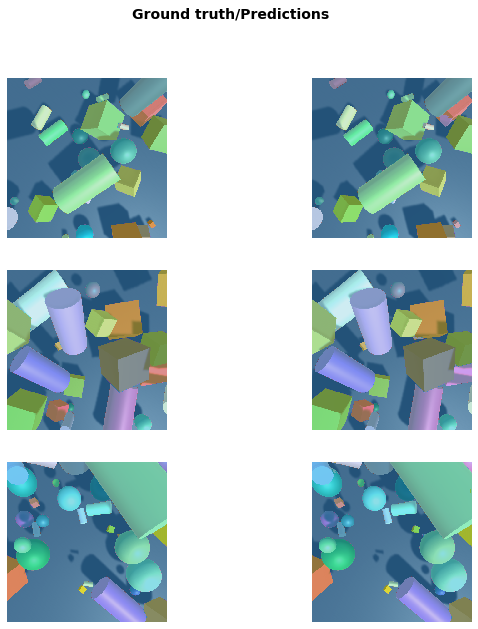

In [48]:
learn.show_results(rows=3, figsize=(10,10))

In [49]:
learn.unfreeze()

In [50]:
lrs = slice(1e-6,lr/10)

In [51]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_segmentation,time
0,0.018629,0.024398,0.980553,04:37
1,0.018778,0.023461,0.980996,04:36
2,0.018003,0.027225,0.978908,04:36
3,0.017713,0.024321,0.980588,04:37
4,0.017857,0.024568,0.980945,04:36
5,0.018006,0.024371,0.980704,04:37
6,0.018711,0.023609,0.981016,04:37
7,0.016826,0.024774,0.981404,04:37
8,0.016017,0.025130,0.980888,05:15
9,0.015935,0.023801,0.981647,05:33


In [52]:
learn.save('stage-2-big')

In [53]:
learn.load('stage-2-big');

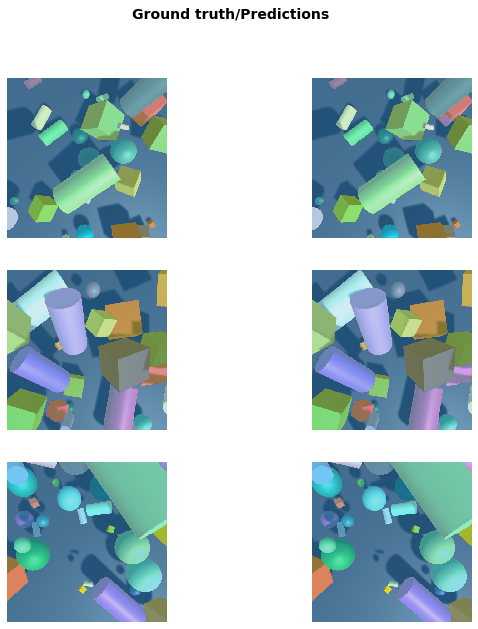

In [54]:
learn.show_results(rows=3, figsize=(10,10))

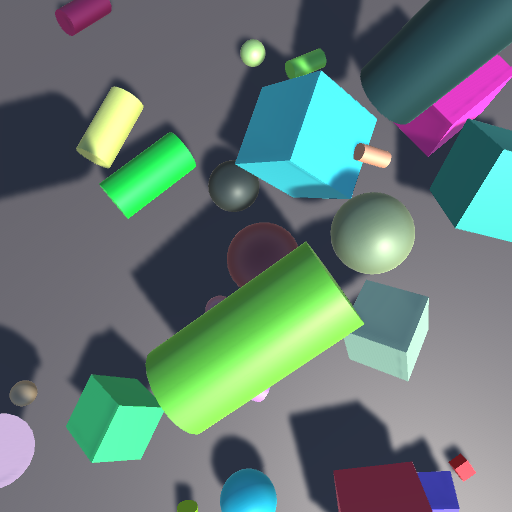

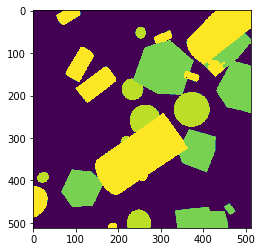

In [55]:
img = open_image((path / 'val').ls()[0])
img
display(img)
plt.imshow(learn.predict(img)[1].squeeze())

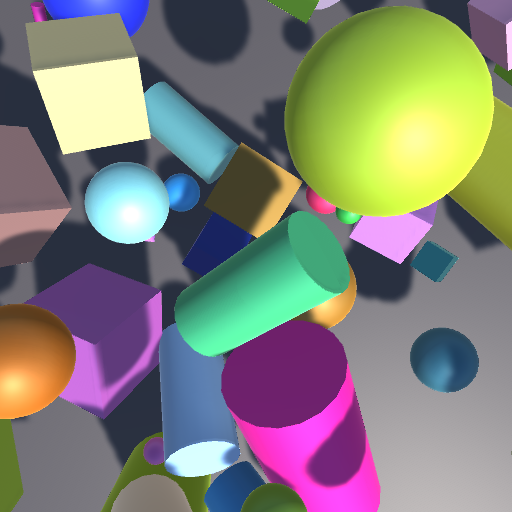

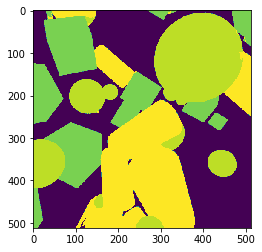

In [56]:
img = open_image((path / 'val').ls()[10])
img
display(img)
plt.imshow(learn.predict(img)[1].squeeze())